# Librerias

In [65]:
# Librerias basicas 
import numpy as np 
import pandas as pd 
import os

# Visualizacióon
import matplotlib.pyplot as plt
import seaborn as sns 
from plotly import express as px
from scipy import stats

# Funciones auxiliares sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score, balanced_accuracy_score, confusion_matrix, roc_curve, auc, accuracy_score, mean_squared_error, mean_absolute_error, r2_score, classification_report # Metricas
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Guardar modelos
import pickle

# Models
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

# WoE
from category_encoders import *

# Preprocesamiento de datos
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


# Plot de matriz de confusion normalizada en actuals
from utils import plot_confusion_matrix, get_artifact_filename

# Optimizacion de hiperparametros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact
from functools import partial

#Guardado de objetos en archivos joblib
from joblib import load, dump

import warnings
warnings.filterwarnings("ignore")

## Optuna

Para ejecutar optuna:

> _optuna-dasboard sqlite:///db2.sqlite3 –port 8081_

# Rutas

In [49]:
#Subimos dos niveles para quedar en la carpeta que contiene input y lab2-mcd-austral
BASE_DIR = './'

#Datos de entrenamiento 
PATH_TO_TRAIN= os.path.join(BASE_DIR, "dataset_pesos.csv")

#Salida de modelos entrenados
PATH_TO_MODELS = os.path.join(BASE_DIR, "work/models")

#Artefactos a subir a optuna
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "work/optuna_temp_artifacts")

#Artefactos que optuna gestiona
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "work/optuna_artifacts")

# Dataset

In [50]:
df = pd.read_csv(PATH_TO_TRAIN, sep=';')
df.head(1)

,Unnamed: 0,Ejercicio,Tipo_Cpbte,N°_Entrada,Entidad_Nº,Cod_Ret,Fte_Fin.,Cuit/DniOtros,Clase_Registro,Clase_Gasto,Glosa,Sueldo,texto_limpio,pesos,cuentas_sueldo,pesos_cuentas
0,0,2021,AF,137,25,217,10,710,ANT,NaN,RES 7/21 ANTICIPO SUB. Y SUBVEN. CTA 360000200...,0,ANTICIPO SUB SUBVEN,95,360000200981158,4


# EDA

In [ ]:
# TODO

# Preprocesamiento

El pre-procesamiento de datos consiste en imputar los NA encontrados.

In [ ]:
# TODO

In [51]:
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Feature Engineering

En esta sección buscamos crear nuevas variables que permitan enriquecer el dataset y que permitan a los modelos obtener mejores scores.

### Variables numéricas: Normalizar

Casi todas las variables numéricas presentan outliers. Realizamos la normalización como ejercicio práctico, entendiendo que no afectará al modelo de forma negativa, aunque esta no sea neceria para los modelos que utilizaremos en la próxima sección.

### Variables categóricas: One Hot Encoding

In [52]:
# onehot encoding
df.join(pd.get_dummies(df[["Tipo_Cpbte"]]))
df.drop(columns=["Tipo_Cpbte"], inplace=True)

df.join(pd.get_dummies(df[["Clase_Registro"]]))
df.drop(columns=["Clase_Registro"], inplace=True)

df.join(pd.get_dummies(df[["Clase_Gasto"]]))
df.drop(columns=["Clase_Gasto"], inplace=True)



# Separa la base de Test y Train

En esta sección haremos un split del dataset en Train y Test considerando un size de 0.2

In [53]:
SEED = 12345
TEST_SIZE = 0.2

Train y Test del dataset original

In [57]:
df.columns

Index(['Ejercicio', 'N°_Entrada', 'Entidad_Nº', 'Cod_Ret', 'Fte_Fin.',
       'Cuit/DniOtros', 'Glosa', 'Sueldo', 'texto_limpio', 'pesos',
       'cuentas_sueldo', 'pesos_cuentas'],
      dtype='object')

In [73]:
df_1 = df.copy()
columns_original = ["Sueldo","Glosa","N°_Entrada","Ejercicio", "texto_limpio", "cuentas_sueldo", "pesos","pesos_cuentas"]
X_original = df_1.drop(columns = columns_original)
y_original = df_1.Sueldo

# División en conjuntos de entrenamiento y prueba
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original, y_original, test_size=TEST_SIZE, random_state=SEED)

In [74]:
# Combinar X_train y y_train en un solo DataFrame
train_original = pd.concat([X_train_original, y_train_original], axis=1)

# Combinar X_test y y_test en un solo DataFrame
test_original = pd.concat([X_test_original, y_test_original], axis=1)

Train y Test del dataset con el score

In [61]:
df_2 = df.copy()
# X = df.drop(columns = ["Sueldo","Glosa","N°_Entrada","Ejercicio", "Cod_Ret"])
X_pesos = df_2.drop(columns = ["Sueldo","Glosa","N°_Entrada","Ejercicio", "texto_limpio", "cuentas_sueldo"])
y_pesos = df_2.Sueldo

# División en conjuntos de entrenamiento y prueba
X_train_pesos, X_test_pesos, y_train_pesos, y_test_pesos = train_test_split(X_pesos, y_pesos, test_size=TEST_SIZE, random_state=SEED)

In [62]:
# Combinar X_train y y_train en un solo DataFrame
train_pesos = pd.concat([X_train_pesos, y_train_pesos], axis=1)

# Combinar X_test y y_test en un solo DataFrame
test_pesos = pd.concat([X_test_pesos, y_test_pesos], axis=1)

Resultados del split

In [75]:
conjuntos = {"X_train": X_train_original, "X_test": X_test_original, "y_train": y_train_original, "y_test": y_test_original}
for key, value in conjuntos.items():
    print(f"{key}: {len(value)} filas")

X_train: 121778 filas
X_test: 30445 filas
y_train: 121778 filas
y_test: 30445 filas


# Modelos

A continuación vamos a hacer la optimización de hiperparámetros, entrenamiento y validación de los modelos utilizando el framework de optuna, que nos provee una aplicación web para ir monitoreando el progreso de la optimización. Se utilizará además 5 fold cross validation.

### Modelo I: _Random Forest Classifier_

In [77]:
def cv_es_rfc_objective(trial):

    #Parametros
    rfc_params = {      
                        #'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                        'max_depth': trial.suggest_int('max_depth', 3, 15)
                        #'max_depth': trial.suggest_int('max_depth', 3, 4)
                        # 'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                        # 'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                        # 'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
                        # 'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
                        } 

    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo RandomForestClassifier con los parámetros sugeridos
        rfc_model = RandomForestClassifier(**rfc_params, random_state=42)
        
        # Entrenar el modelo
        rfc_model.fit(X_if, y_if)
        
        # Acumular los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        scores_ensemble += rfc_model.predict_proba(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += accuracy_score(y_oof, rfc_model.predict(X_oof)) / n_splits


    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    #Grabo natriz de confusion
    #Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    #Grabo archivo
    plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    #Asocio al trial
    upload_artifact(trial, cm_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = accuracy_score(y_test, scores_ensemble.argmax(axis=1))
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)

Iniciamos optuna para el modelo RandomForestClassifier: dataset original

In [78]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

# Train y Test
X_train = X_train_original
y_train = y_train_original
X_test = X_test_original
y_test = y_test_original
train = train_original
test = test_original

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  # Specify the storage URL here.
                            study_name="RandomForestClasiffier-original",
                            load_if_exists = True)

# Usamos partial para pasar x_train y x_test a la función objetivo
# objective_with_data = partial(cv_es_rfc_objective, X_train, y_train, train, test)

#Corro la optimizacion
study.optimize(cv_es_rfc_objective, n_trials=10)

[I 2024-08-10 21:20:17,235] Using an existing study with name 'RandomForestClasiffier-original' instead of creating a new one.
[I 2024-08-10 21:20:43,925] Trial 4 finished with value: 0.9682290835532431 and parameters: {'max_depth': 9}. Best is trial 4 with value: 0.9682290835532431.
[I 2024-08-10 21:21:05,921] Trial 5 finished with value: 0.9704626406786974 and parameters: {'max_depth': 11}. Best is trial 5 with value: 0.9704626406786974.
[I 2024-08-10 21:21:27,767] Trial 6 finished with value: 0.9715958529199344 and parameters: {'max_depth': 14}. Best is trial 6 with value: 0.9715958529199344.
[I 2024-08-10 21:21:52,985] Trial 7 finished with value: 0.9704626406786974 and parameters: {'max_depth': 11}. Best is trial 6 with value: 0.9715958529199344.
[I 2024-08-10 21:22:16,178] Trial 8 finished with value: 0.9681716031874961 and parameters: {'max_depth': 8}. Best is trial 6 with value: 0.9715958529199344.
[I 2024-08-10 21:22:38,317] Trial 9 finished with value: 0.9689763482003872 and 

Iniciamos optuna para el modelo RandomForestClassifier: dataset con scores

In [81]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

# Train y Test
X_train = X_train_pesos
y_train = y_train_pesos
X_test = X_test_pesos
y_test = y_test_pesos
train = train_pesos
test = test_pesos

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  # Specify the storage URL here.
                            study_name="RandomForestClasiffier-pesos",
                            load_if_exists = True)

#Corro la optimizacion
study.optimize(cv_es_rfc_objective, n_trials=10)

[I 2024-08-10 22:07:02,774] Using an existing study with name 'RandomForestClasiffier-pesos' instead of creating a new one.
[I 2024-08-10 22:07:37,585] Trial 1 finished with value: 0.980062089341368 and parameters: {'max_depth': 11}. Best is trial 1 with value: 0.980062089341368.
[I 2024-08-10 22:08:13,952] Trial 2 finished with value: 0.980062089341368 and parameters: {'max_depth': 11}. Best is trial 1 with value: 0.980062089341368.
[I 2024-08-10 22:08:45,747] Trial 3 finished with value: 0.9802098965259686 and parameters: {'max_depth': 13}. Best is trial 3 with value: 0.9802098965259686.
[I 2024-08-10 22:09:15,897] Trial 4 finished with value: 0.980062089341368 and parameters: {'max_depth': 11}. Best is trial 3 with value: 0.9802098965259686.
[I 2024-08-10 22:09:46,989] Trial 5 finished with value: 0.9800949347829948 and parameters: {'max_depth': 12}. Best is trial 3 with value: 0.9802098965259686.
[I 2024-08-10 22:10:20,247] Trial 6 finished with value: 0.9802263243041803 and parame

### Modelo II: _Gradient Boosting Classifier_

In [82]:
def cv_es_gbc_objective(trial):

    #Parametros para LightGBM
    gbc_params = {      
                       # 'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
                       # 'max_depth': trial.suggest_int('max_depth', 3, 10),
                        ##'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                        #'subsample': trial.suggest_uniform('subsample', 0.5, 1.0)
                        #'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                        #'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 'auto']),
                        #'loss': trial.suggest_categorical('loss', ['deviance', 'exponential']),
                        } 

    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo RandomForestClassifier con los parámetros sugeridos
        gbc_model = GradientBoostingClassifier(**gbc_params, random_state=42)
        
        # Entrenar el modelo
        gbc_model.fit(X_if, y_if)
        
        # Acumular los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        scores_ensemble += gbc_model.predict_proba(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += accuracy_score(y_oof, gbc_model.predict(X_oof)) / n_splits


    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    


    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = accuracy_score(y_test, scores_ensemble.argmax(axis=1))
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)

Iniciamos optuna para el modelo GradientBoostingClassifier: dataset original

In [85]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

# Train y Test
X_train = X_train_original
y_train = y_train_original
X_test = X_test_original
y_test = y_test_original
train = train_original
test = test_original

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  # Specify the storage URL here.
                            study_name="gbc-original",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_gbc_objective, n_trials=10)

[I 2024-08-10 22:31:46,513] A new study created in RDB with name: gbc-original
[I 2024-08-10 22:32:09,915] Trial 0 finished with value: 0.9667756210072052 and parameters: {'learning_rate': 0.08010917494262017}. Best is trial 0 with value: 0.9667756210072052.
[I 2024-08-10 22:32:48,705] Trial 1 finished with value: 0.971185277819239 and parameters: {'learning_rate': 0.6206163321720828}. Best is trial 1 with value: 0.971185277819239.
[I 2024-08-10 22:33:19,053] Trial 2 finished with value: 0.9667345674081903 and parameters: {'learning_rate': 0.025777977961861875}. Best is trial 1 with value: 0.971185277819239.
[I 2024-08-10 22:33:51,418] Trial 3 finished with value: 0.8815385374253708 and parameters: {'learning_rate': 0.0012126232002202782}. Best is trial 1 with value: 0.971185277819239.
[I 2024-08-10 22:34:22,970] Trial 4 finished with value: 0.9667345674081903 and parameters: {'learning_rate': 0.0251120193448501}. Best is trial 1 with value: 0.971185277819239.
[I 2024-08-10 22:34:56,87

Iniciamos optuna para el modelo GradientBoostingClassifier: dataset con scores

In [86]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

# Train y Test
X_train = X_train_pesos
y_train = y_train_pesos
X_test = X_test_pesos
y_test = y_test_pesos
train = train_pesos
test = test_pesos

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  # Specify the storage URL here.
                            study_name="gbc-scores",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_gbc_objective, n_trials=10)

[I 2024-08-10 22:37:42,377] A new study created in RDB with name: gbc-scores
[I 2024-08-10 22:38:29,095] Trial 0 finished with value: 0.9793723057342907 and parameters: {'learning_rate': 0.35817942178526757}. Best is trial 0 with value: 0.9793723057342907.
[I 2024-08-10 22:39:09,501] Trial 1 finished with value: 0.9550740050774256 and parameters: {'learning_rate': 0.0061731838546477385}. Best is trial 0 with value: 0.9793723057342907.
[I 2024-08-10 22:39:46,168] Trial 2 finished with value: 0.8815385374253708 and parameters: {'learning_rate': 0.0014277055861603252}. Best is trial 0 with value: 0.9793723057342907.
[I 2024-08-10 22:40:28,458] Trial 3 finished with value: 0.9769827147230541 and parameters: {'learning_rate': 0.9858506514191256}. Best is trial 0 with value: 0.9793723057342907.
[I 2024-08-10 22:41:03,428] Trial 4 finished with value: 0.9796679275210094 and parameters: {'learning_rate': 0.39655729607463797}. Best is trial 4 with value: 0.9796679275210094.
[I 2024-08-10 22:41:

### Métricas y Gráficos

#### Gráfico I: Accuracy en Train y Test

<Axes: title={'center': 'Train y test'}, xlabel='study'>

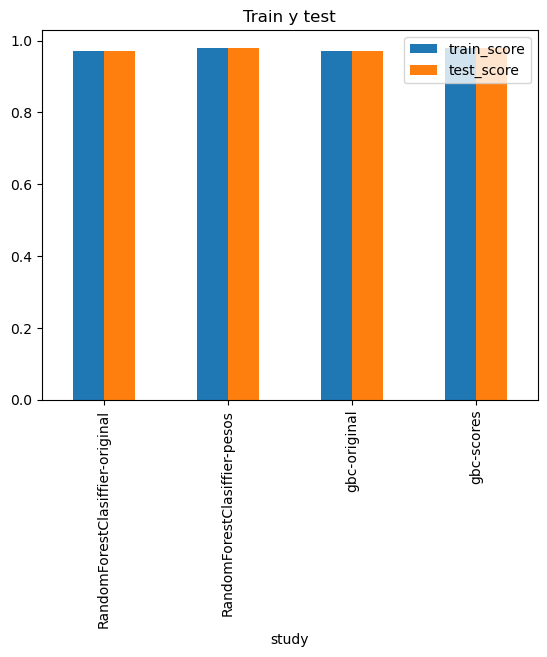

In [87]:
storage = 'sqlite:///prueba.sqlite3'
studies_names = ['RandomForestClasiffier-original', 
           'RandomForestClasiffier-pesos', 
           'gbc-original',
           'gbc-scores']

studies = [optuna.load_study(study_name=study_name, storage=storage) for study_name in studies_names]

df_result = pd.DataFrame()
df_result['study'] = [study.study_name for study in studies]
df_result['best_params'] = [study.best_params for study in studies]
df_result['train_score'] = [study.best_trial.value for study in studies]
df_result['test_score'] = [study.best_trial.user_attrs['test_score'] for study in studies]
df_result.set_index('study', inplace=True   )

df_result[['test_score','train_score']].sort_values('test_score',ascending=False,inplace=True,)

df_result.plot(kind='bar', title='Train y test')

#### Gráfico II: Curva ROC

In [92]:
# entrenar todos los modelo para hacer predicciones y construir curva ROC
m_rf_original = RandomForestClassifier(**df_result["best_params"]["RandomForestClasiffier-original"],random_state=42)
m_rf_original.fit(X_train_original, y_train_original)

# entrenar todos los modelo para hacer predicciones y construir curva ROC
m_rf_pesos = RandomForestClassifier(**df_result["best_params"]["RandomForestClasiffier-pesos"],random_state=42)
m_rf_pesos.fit(X_train_pesos, y_train_pesos)

m_gb_original = GradientBoostingClassifier(**df_result["best_params"]["gbc-original"],random_state=42)
m_gb_original.fit(X_train_original, y_train_original)

m_gb_pesos = GradientBoostingClassifier(**df_result["best_params"]["gbc-scores"],random_state=42)
m_gb_pesos.fit(X_train_pesos, y_train_pesos)

GradientBoostingClassifier(learning_rate=0.39655729607463797, random_state=42)

In [93]:
# hacer las predicciones
preds = pd.DataFrame()
preds["m_rf_original"] = m_rf_original.predict_proba(X_test_original)[:,1]
preds["m_gb_original"] = m_gb_original.predict_proba(X_test_original)[:,1]
preds["m_rf_pesos"] = m_rf_pesos.predict_proba(X_test_pesos)[:,1]
preds["m_gb_pesos"] = m_gb_pesos.predict_proba(X_test_pesos)[:,1]

In [94]:
# Calcular la curva ROC y el AUC

fpr_rf_original, tpr_rf_original, _ = roc_curve(y_test_original, preds["m_rf_original"])
roc_auc_rf_original = auc(fpr_rf_original, tpr_rf_original)

fpr_gb_original, tpr_gb_original, _ = roc_curve(y_test_original, preds["m_rf_original"])
roc_auc_gb_original = auc(fpr_gb_original, tpr_gb_original)

fpr_rf_pesos, tpr_rf_pesos, _ = roc_curve(y_test_pesos, preds["m_rf_pesos"])
roc_auc_rf_pesos = auc(fpr_rf_pesos, tpr_rf_pesos)

fpr_gb_pesos, tpr_gb_pesos, _ = roc_curve(y_test_pesos, preds["m_rf_pesos"])
roc_auc_gb_pesos = auc(fpr_gb_pesos, tpr_gb_pesos)



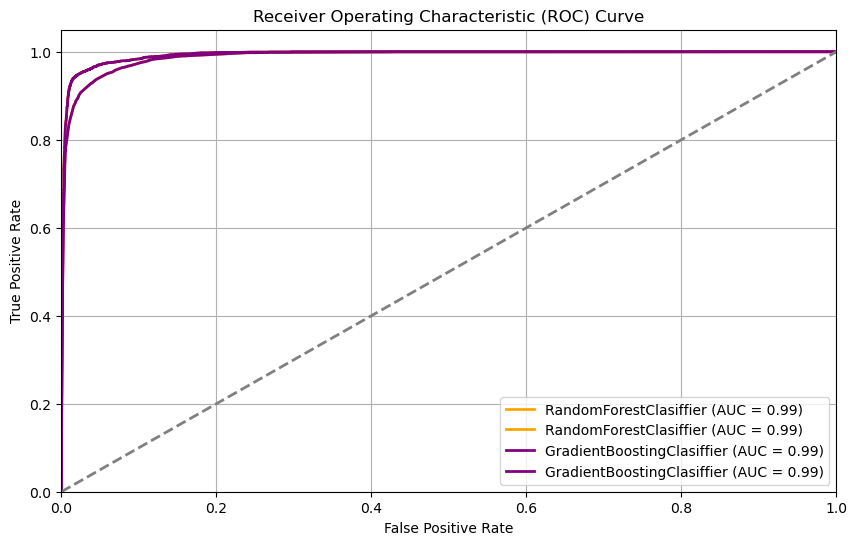

In [95]:
plt.figure(figsize=(10, 6))



plt.plot(fpr_rf_original, tpr_rf_original, color='orange', lw=2, label=f'RandomForestClasiffier (AUC = {roc_auc_rf_original:.2f})')
plt.plot(fpr_rf_pesos, tpr_rf_pesos, color='orange', lw=2, label=f'RandomForestClasiffier (AUC = {roc_auc_rf_pesos:.2f})')
plt.plot(fpr_gb_original, tpr_gb_original, color='purple', lw=2, label=f'GradientBoostingClasiffier (AUC = {roc_auc_gb_original:.2f})')
plt.plot(fpr_gb_pesos, tpr_gb_pesos, color='purple', lw=2, label=f'GradientBoostingClasiffier (AUC = {roc_auc_gb_pesos:.2f})')

# Graficar la línea de referencia
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

# Configurar detalles del gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Mostrar el gráfico
plt.show()

#### Gráfico III: Matríz de confusión

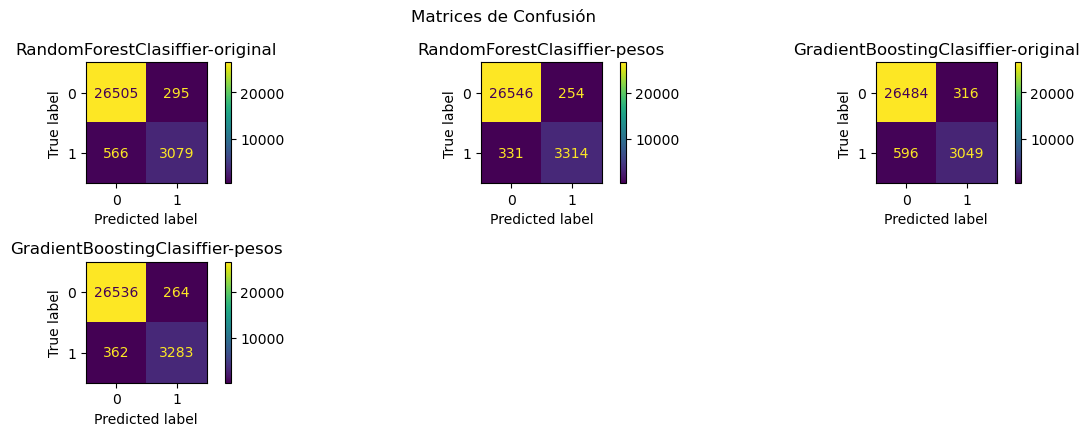

In [100]:
fig, ax = plt.subplots(3, 3, figsize=(12, 6))


cm_rf_original= metrics.confusion_matrix(y_test, m_rf_original.predict(X_test_original))
cm_gb_original= metrics.confusion_matrix(y_test, m_gb_original.predict(X_test_original))
cm_rf_pesos= metrics.confusion_matrix(y_test, m_rf_pesos.predict(X_test_pesos))
cm_gb_pesos= metrics.confusion_matrix(y_test, m_gb_pesos.predict(X_test_pesos))

metrics.ConfusionMatrixDisplay(confusion_matrix = cm_rf_original, display_labels = [0, 1]).plot(ax=ax[0,0])
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_rf_pesos, display_labels = [0, 1]).plot(ax=ax[0,1])
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_gb_original, display_labels = [0, 1]).plot(ax=ax[0,2])
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_gb_pesos, display_labels = [0, 1]).plot(ax=ax[1,0])


ax[0,0].set_title('RandomForestClasiffier-original')
ax[0,1].set_title('RandomForestClasiffier-pesos')
ax[0,2].set_title('GradientBoostingClasiffier-original')
ax[1,0].set_title('GradientBoostingClasiffier-pesos')


fig.delaxes(ax[1, 1])
fig.delaxes(ax[1, 2])
fig.delaxes(ax[2, 0])
fig.delaxes(ax[2, 1])
fig.delaxes(ax[2, 2])

plt.suptitle("Matrices de Confusión")
plt.tight_layout()

plt.show()

#### Métricas del RandomForest

In [101]:
print(classification_report(y_test_original,m_rf_original.predict(X_test_original)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     26800
           1       0.91      0.84      0.88      3645

    accuracy                           0.97     30445
   macro avg       0.95      0.92      0.93     30445
weighted avg       0.97      0.97      0.97     30445



In [102]:
print(classification_report(y_test_pesos,m_rf_pesos.predict(X_test_pesos)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26800
           1       0.93      0.91      0.92      3645

    accuracy                           0.98     30445
   macro avg       0.96      0.95      0.95     30445
weighted avg       0.98      0.98      0.98     30445



#### Métricas del GradientBoosting

In [103]:
print(classification_report(y_test_original,m_gb_original.predict(X_test_original)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     26800
           1       0.91      0.84      0.87      3645

    accuracy                           0.97     30445
   macro avg       0.94      0.91      0.93     30445
weighted avg       0.97      0.97      0.97     30445



In [104]:
print(classification_report(y_test_pesos,m_gb_pesos.predict(X_test_pesos)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26800
           1       0.93      0.90      0.91      3645

    accuracy                           0.98     30445
   macro avg       0.96      0.95      0.95     30445
weighted avg       0.98      0.98      0.98     30445

